# **DM - Anomaly Detection Exercise**

#### *Axel ROUSSE, 20/12/2024*

Voici l'approche développée après que vous êtes venus me solliciter pour répondre à cette question : **"Développez un algorithme afin de détecter les fenêtres anormales".**

## **Formulation du problème & démarche prévue**

Pour chaque fenêtre, nous disposons de séries temporelles pour chacun des 11 paramètres mesurés. C'est pourquoi une fenêtre peut être considérée comme **anormale** lorsqu'elle présente des séries temporelles peu communes vis-à-vis de l'ensemble des fenêtres.  

Ainsi, dans l'optique de comparer les fenêtres entre elles en termes de séries temporelles, il nous vient assez naturellement l'idée de raisonner sur les **moyenne et variance** de ces séries temporelles.

Nous formulons donc le problème de la manière suivante :

#### **À l'aide de méthodes de détection d'anomalies usuelles, nous cherchons à détecter les fenêtres anormales au sens des moyenne et variance des séries temporelles associées aux paramètres mesurés pour cette fenêtre.**

Alors, il nous semble pertinent, après avoir quelque peu nettoyé et transformé les données brutes, d'utiliser les techniques *Elliptic Envelope*, *Isolation Forest*, *Local Outlier Factor* et *Minimum Covariance Determinant (MCD)*.

## **Analyse exploratoire des données**

Commençons par importer les librairies utiles :

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

Définissons également des fonctions utiles, nous permettant de calculer la matrice de covariance d'un vecteur, la distance de *Mahalanobis* relative à un vecteur ainsi que le *Minimum Covariance Determinant (MCD)* (utilisé plus loin pour la détection d'outliers) :

In [96]:
def covariance_matrix(X):
    mean = np.mean(X, axis=0)
    return np.cov((X - mean).T)

def mahalanobis_distance(X, mean, cov_matrix):
    inv_cov = np.linalg.inv(cov_matrix)
    diffs = X - mean
    #Calling diagonal to take only relative measure of distance with regards to the mean of distribution, not comparing to others
    return np.sqrt(np.diag(np.dot(np.dot(diffs, inv_cov), diffs.T)))

# MCD implementation
def mcd(X, h):
    # here we randomly select subsets
    np.random.seed(42)
    best_det = float('inf')
    best_subset = None
    
    # testing 100 random subsets of h points
    for _ in range(100):
        subset = X[np.random.choice(X.shape[0], h, replace=False)]
        cov_matrix = covariance_matrix(subset)
        det = np.linalg.det(cov_matrix)
        if det < best_det:
            best_det = det
            best_subset = subset
    
    # finding the best subset's mean and covariance matrix
    best_mean = np.mean(best_subset, axis=0)
    best_cov = covariance_matrix(best_subset)
    
    # deriving the Mahalanobis distances for all points
    distances = mahalanobis_distance(X, best_mean, best_cov)
    return distances

Chargeons ensuite le *dataset*, et observons la forme des données pour une valeur de `day_cycle_window` choisie aléatoirement :

In [97]:
df_base = pd.read_csv("data/dataset.csv")

In [98]:
sample_value = df_base['day_cycle_window'].sample(1).iloc[0]
print(f"Random window selected: {sample_value}")
df_base[df_base['day_cycle_window'] == sample_value]

Random window selected: 3_3_55


,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
104814,3_3_55,-1.003925,-1.125887,-1.216769,-1.288488,-0.948078,-1.232785,-1.145881,-1.119020,1.425620,1.014214,-1.087235
104815,3_3_55,-1.004892,-1.131296,-1.218775,-1.293322,-0.955711,-1.240047,-1.151565,-1.124572,1.435764,1.002027,-1.090138
104816,3_3_55,-1.004892,-1.131296,-1.218775,-1.305929,-0.955711,-1.240047,-1.151565,-1.124572,1.435764,1.002027,-1.090138
104817,3_3_55,-1.009273,-1.131296,-1.223492,-1.307730,-0.965320,-1.240047,-1.151565,-1.124572,1.414499,0.959827,-1.090138
104818,3_3_55,-1.017596,-1.131296,-1.231802,-1.307730,-0.982250,-1.240047,-1.151565,-1.124572,1.412137,0.942288,-1.090138
...,...,...,...,...,...,...,...,...,...,...,...,...
104909,3_3_55,-0.306601,-0.122251,-0.237950,-0.112310,-0.461743,-0.411953,-0.218051,-0.306664,1.171693,0.146073,-0.437946
104910,3_3_55,-0.322574,-0.172119,-0.267127,-0.129224,-0.461743,-0.437102,-0.234339,-0.311909,1.302252,0.146073,-0.483363
104911,3_3_55,-0.350264,-0.255648,-0.342838,-0.171570,-0.460560,-0.481441,-0.281141,-0.342703,1.480539,0.172596,-0.576796
104912,3_3_55,-0.390832,-0.333961,-0.407281,-0.243874,-0.467318,-0.541826,-0.329471,-0.371554,1.504341,0.203856,-0.666800


On retrouve bien que pour chaque valeur de `day_cycle_window` (*ie.* pour chaque fenêtre) et pour chaque type de paramètre *p*, on dispose d'un ensemble de $100$ valeurs temporelles.

En se penchant de plus près sur les nombres précis de valeurs temporelles associées à chaque fenêtre, on remarque la présence de $15$ fenêtres anormales, *ie.* contenant strictement moins de 100 valeurs pour chaque paramètre *p* :

In [101]:
window_counts = df_base['day_cycle_window'].value_counts()
print(window_counts.describe())
window_counts.tail(20)

count    1637.000000
mean       99.390348
std         6.944223
min         2.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: count, dtype: float64


day_cycle_window
2_2_4      100
2_1_158    100
2_2_3      100
2_2_2      100
2_1_163    100
4_1_49      85
4_4_160     76
1_1_68      75
2_2_76      62
1_3_6       53
1_4_17      50
2_3_145     32
4_3_65      22
3_2_52      17
1_5_94      17
4_2_181      3
1_2_181      3
3_1_181      3
2_1_181      2
3_3_181      2
Name: count, dtype: int64

Étant donné le nombre très réduit de fenêtres "incomplètes" ($15$ fenêtres), nous décidons de ne pas les considérer dans la suite, afin de ne pas perturber l'étude des anomalies :

In [103]:
valid_windows = window_counts[window_counts >= 100].index

df_base_filtered = df_base[df_base['day_cycle_window'].isin(valid_windows)]

Représentons maintenant, pour chaque paramètre *p*, les $100$ valeurs d'une fenêtre quelconque, choisie aléatoirement, sous forme de graphes temporels :

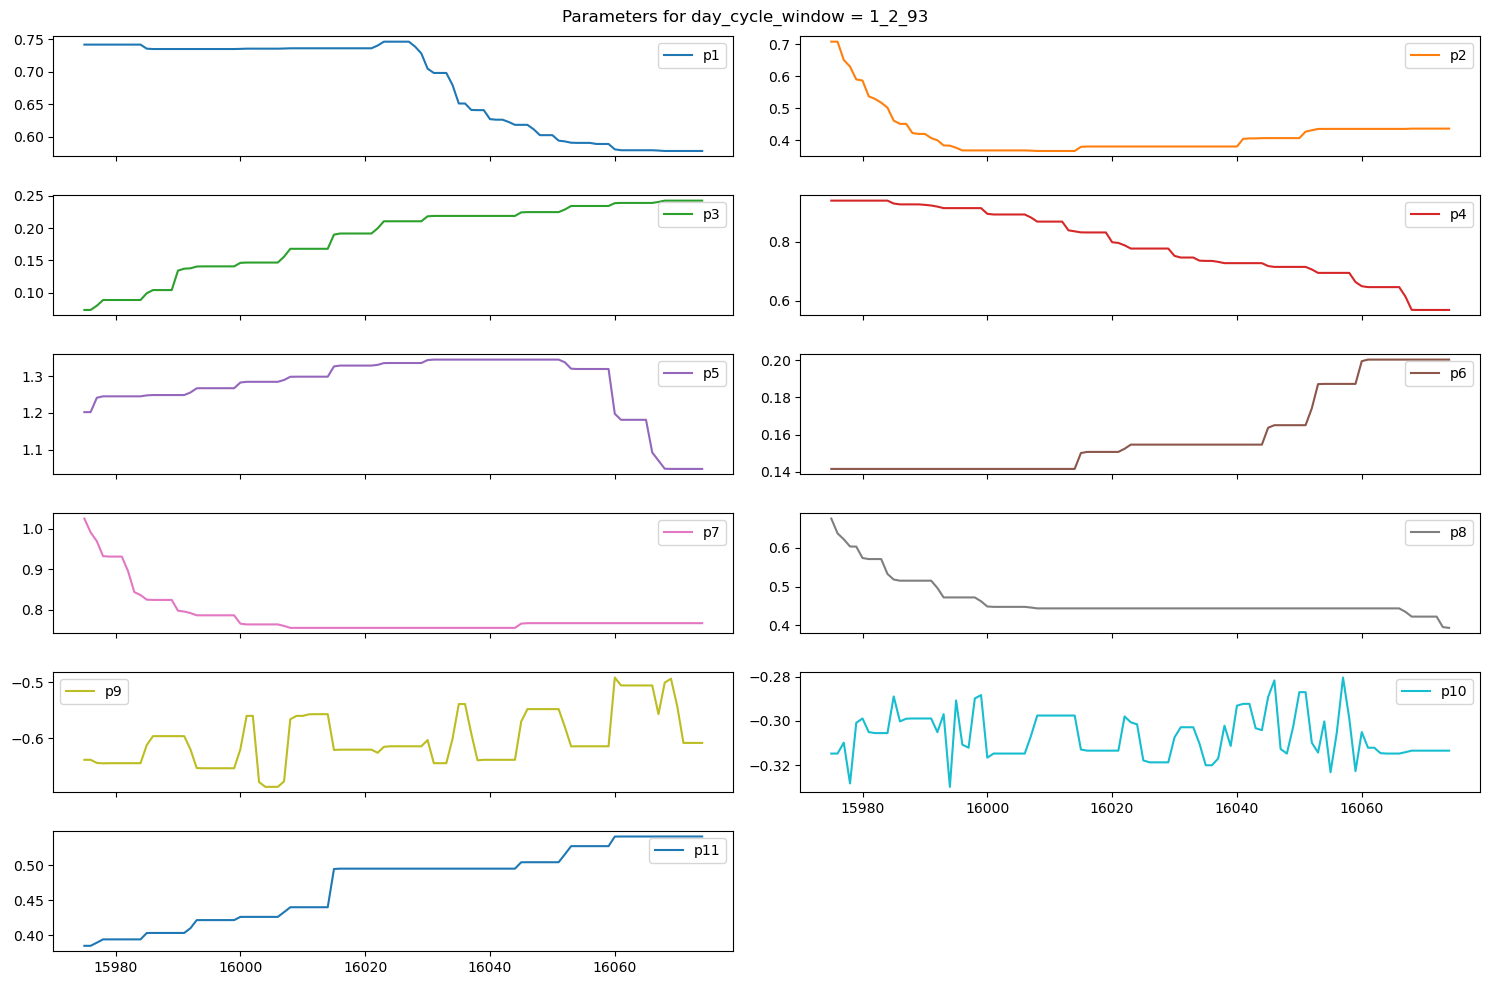

In [104]:
random_window = df_base_filtered['day_cycle_window'].sample(1).iloc[0]

example_df = df_base_filtered[df_base_filtered['day_cycle_window'] == random_window]

# Plot the values of all parameters
example_df.plot(kind='line', subplots=True, layout=(len(example_df.columns)//2, 2), figsize=(15, 10), title=f'Parameters for day_cycle_window = {random_window}')
plt.tight_layout()
plt.show()

Comme évoqué précédemment, définissons une **fenêtre anormale** comme une **fenêtre présentant une moyenne et une variance temporelles significativement différentes de celles de la majorité des fenêtres**.  

Suivant cette définition, nous commençons par transformer notre *dataframe* afin que chaque fenêtre se voit attribuer une moyenne temporelle et une variance temporelle pour chaque paramètre *p*. Chaque fenêtre n'apparaît alors qu'une fois dans notre *dataframe* transformé, avec un total de $22$ valeurs ($2$ par paramètre) :

In [105]:
agg_dict = {col: ['mean', 'var'] for col in df_base_filtered.columns if col != 'day_cycle_window'}
df = df_base_filtered.groupby(by='day_cycle_window', as_index=False).agg(agg_dict)

# Flatten the MultiIndex columns and rename them
df.columns = ['_'.join(col).strip() for col in df.columns.values if col != 'day_cycle_window']

# Rename 'day_cycle_window_' to 'day_cycle_window'
df.rename(columns={'day_cycle_window_': 'day_cycle_window'}, inplace=True)

In [106]:
df

,day_cycle_window,p1_mean,p1_var,p2_mean,p2_var,p3_mean,p3_var,p4_mean,p4_var,p5_mean,...,p7_mean,p7_var,p8_mean,p8_var,p9_mean,p9_var,p10_mean,p10_var,p11_mean,p11_var
0,1_1_1,-1.926141,0.349464,-2.456284,0.547064,-2.487394,0.437252,-2.481230,0.399124,-2.388674,...,-2.447148,0.444449,-1.169837,0.594798,2.848242,0.060615,-1.370045,0.454100,-2.500060,0.524854
1,1_1_10,1.204735,0.060495,1.123558,0.058851,1.077596,0.052941,1.128253,0.042763,1.136183,...,1.199106,0.055472,1.308412,0.072353,-0.429810,0.000000,-0.088168,0.000054,1.016565,0.044644
2,1_1_11,0.742475,0.017856,0.703459,0.017657,0.680578,0.015138,0.740626,0.014003,0.768269,...,0.755362,0.016928,0.783155,0.024082,-0.429810,0.000000,-0.091129,0.000061,0.669938,0.014651
3,1_1_12,0.300162,0.007944,0.289058,0.005954,0.289114,0.005544,0.342999,0.006267,0.396993,...,0.324268,0.007274,0.264819,0.011109,-0.429810,0.000000,-0.085217,0.000066,0.303699,0.004739
4,1_1_13,0.140935,0.000045,0.152487,0.000024,0.161874,0.000011,0.200016,0.000051,0.226986,...,0.170042,0.000065,0.068720,0.000119,-0.429810,0.000000,-0.089727,0.000070,0.186059,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,4_4_95,-0.372836,0.000619,0.141482,0.000306,-0.149731,0.001768,0.024193,0.003432,0.623414,...,-0.137674,0.040886,-0.985834,0.000103,0.935814,0.000310,0.716441,0.000014,-0.683516,0.000231
1618,4_4_96,-0.422993,0.001534,0.074675,0.006107,-0.178621,0.001618,-0.197507,0.004865,0.619532,...,0.327148,0.017724,-1.005362,0.000959,0.924742,0.000446,0.226022,0.019562,-0.722753,0.001597
1619,4_4_97,-0.453629,0.000342,0.040768,0.000267,-0.130621,0.001014,-0.370856,0.000319,0.415872,...,0.620583,0.005329,-0.986663,0.006031,0.905289,0.000133,0.171044,0.000007,-0.741979,0.000040
1620,4_4_98,-0.496385,0.000772,0.077945,0.002711,-0.075291,0.005102,-0.444703,0.002297,0.117676,...,0.856212,0.003834,-0.630861,0.008985,0.890961,0.000144,-0.326343,0.280317,-0.652738,0.002955


Dans un premier temps, nous affichons sous forme de *heatmap* la matrice de corrélation des moyennes et variances des paramètres *p*. Le but est de se faire une idée des relations qu'entretiennent les différents paramètres pour l'ensemble des fenêtres :

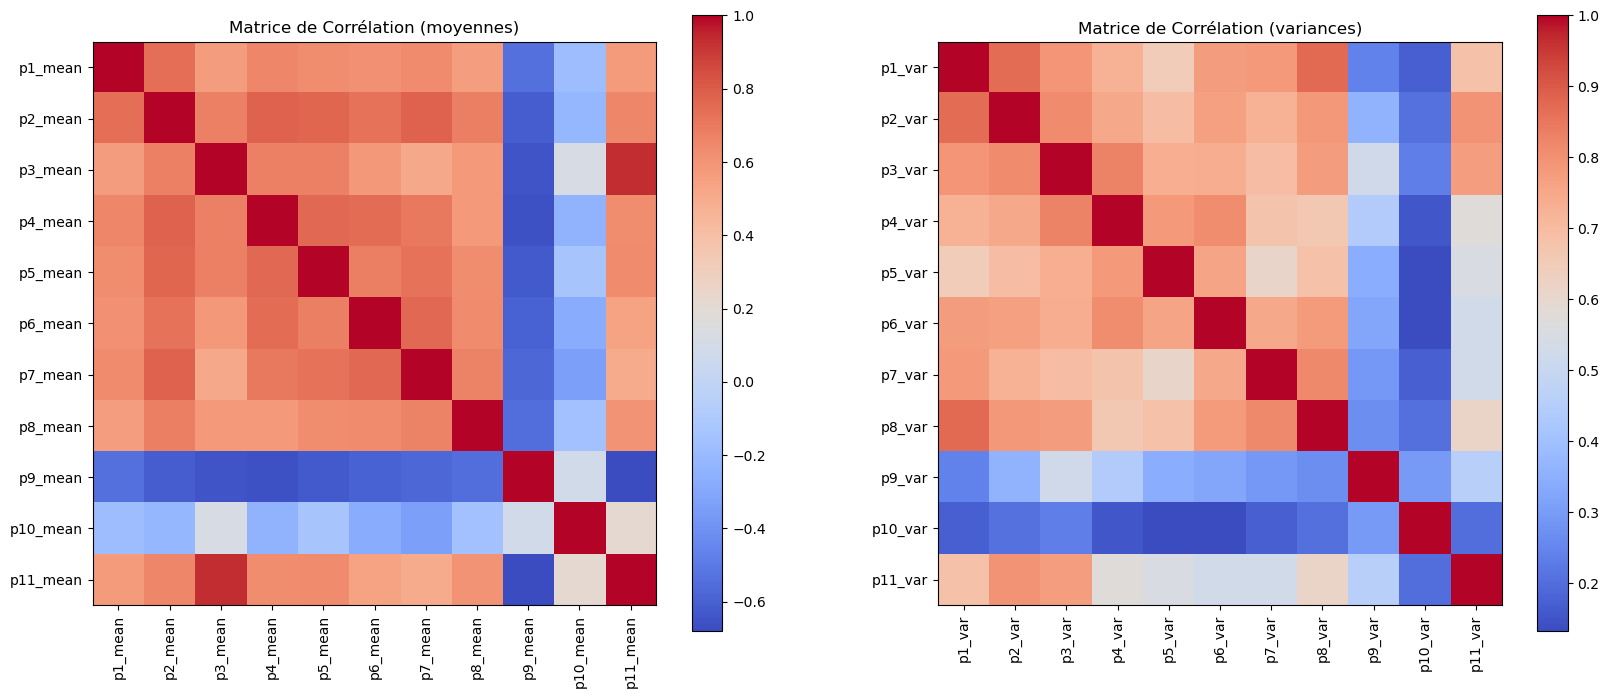

In [107]:
# Calcul de la matrice de corrélation pour les colonnes '_mean'
corr_matrix_mean = df.filter(like='_mean').corr()

# Calcul de la matrice de corrélation pour les colonnes '_var'
corr_matrix_var = df.filter(like='_var').corr()

# Affichage sous forme de heatmap
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Heatmap pour les colonnes '_mean'
axes[0].imshow(corr_matrix_mean, cmap='coolwarm', interpolation='none')
axes[0].set_title("Matrice de Corrélation (moyennes)")
axes[0].set_xticks(range(len(corr_matrix_mean.columns)))
axes[0].set_xticklabels(corr_matrix_mean.columns, rotation=90)
axes[0].set_yticks(range(len(corr_matrix_mean.columns)))
axes[0].set_yticklabels(corr_matrix_mean.columns)
fig.colorbar(axes[0].imshow(corr_matrix_mean, cmap='coolwarm', interpolation='none'), ax=axes[0])

# Heatmap pour les colonnes '_var'
axes[1].imshow(corr_matrix_var, cmap='coolwarm', interpolation='none')
axes[1].set_title("Matrice de Corrélation (variances)")
axes[1].set_xticks(range(len(corr_matrix_var.columns)))
axes[1].set_xticklabels(corr_matrix_var.columns, rotation=90)
axes[1].set_yticks(range(len(corr_matrix_var.columns)))
axes[1].set_yticklabels(corr_matrix_var.columns)
fig.colorbar(axes[1].imshow(corr_matrix_var, cmap='coolwarm', interpolation='none'), ax=axes[1])

plt.show()

Étant donné que la moyenne et la variance associées à un paramètre sont obtenues en agrégeant les 100 observations successives d’une série temporelle pour ce paramètre, on peut dire que:
* Les paramètres dont les moyennes sont fortement corrélées présentent, pour la plupart des fenêtres, des séries temporelles de moyennes similaires, et inversement pour les paramètres faiblement corrélés. Ici, par exemple, on peut dire que pour la plupart des fenêtres, les valeurs de *p3* "évoluent" autour d'une moyenne proche de celle autour de laquelle évoluent les valeurs de *p11*.
* Les paramètres dont les variances sont fortement corrélées présentent, pour la plupart des fenêtres, des séries temporelles de variances similaires, et inversement pour les paramètres faiblement corrélés. Ici, par exemple, on peut dire que pour la plupart des fenêtres, les valeurs de *p9* et de *p10* semblent osciller très différemment autour de leur moyenne par rapport aux valeurs des autres paramètres (en l'occurence, les valeurs de *p9* et de *p10* oscillent plus fortement)

Dans un second temps, nous traçons les distributions des moyennes et variances temporelles de chaque paramètre sur l'ensemble des fenêtres :

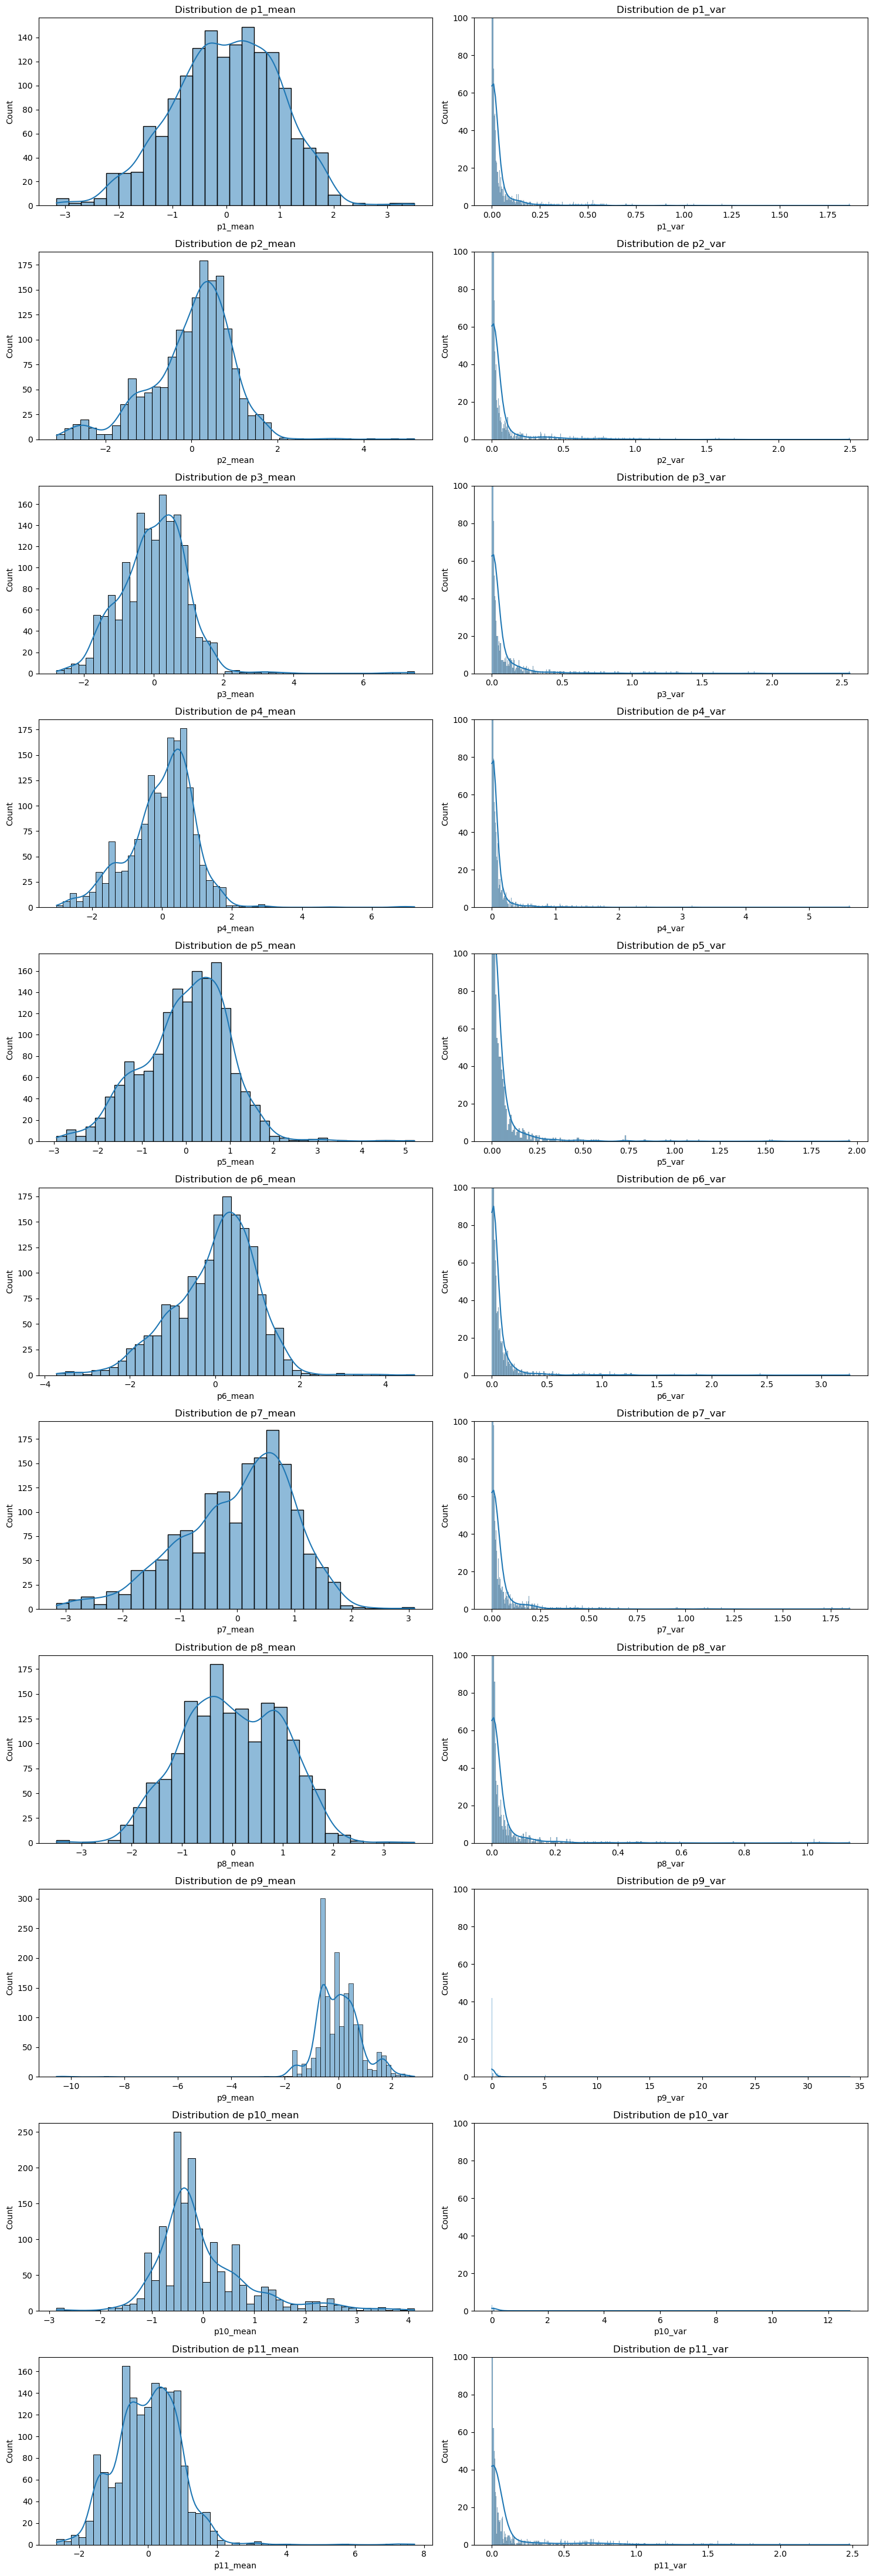

In [108]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = df.select_dtypes(include=[np.number]).columns
# numeric_columns = df.filter(like='_mean').columns

# Définir la taille de la grille de subplots
n_cols = 2  # Nombre de colonnes dans les subplots
n_rows = -(-len(numeric_columns) // n_cols)  # Calculer dynamiquement le nombre de lignes

# Créer la figure avec plusieurs subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Aplatir les axes pour itérer facilement

# Générer un histogramme pour chaque variable
for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution de {column}")
    if 'var' in column:
        axes[i].set_ylim(top=100)

# Supprimer les subplots vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement entre les subplots
plt.tight_layout()
plt.show()

On remarque que:
* les moyennes des paramètres suivent des ditributions unimodales très proches d'une distribution gaussienne, mais avec une asymétrie plus ou moins prononcée pour les 7 premiers paramètres, où l'on trouve plus de valeurs sur la queue gauche que la queue droite.
* les variances (tronquées en ordonnées à $100$ pour mieux visualiser) suivent elles des distributions d'allure exponentielle, avec une immense majorité de variances très proches de $0$.

On remarque alors que pour certains paramètres plus que pour d'autres, principalement *p3*, *p4*, *p9* et *p11*, quelques fenêtres ont des valeurs très éloignées de la moyenne (lorsque les valeurs sont les moyennes des séries temporelles) et très éloignées de $0$ (lorsque les valeurs sont les variances des séries temporelles).  

Nous avons donc bien des fenêtres anormales, en tous cas au sens de certains paramètres. Pour l'instant, nous ne pouvons pas dire si les fenêtres anormales pour un paramètre sont les mêmes que les fenêtres anormales pour les autres paramètres.

Projetons d'abord les valeurs des fenêtres sur certains couples de paramètres afin d'identifier visuellement la présence d'outliers :

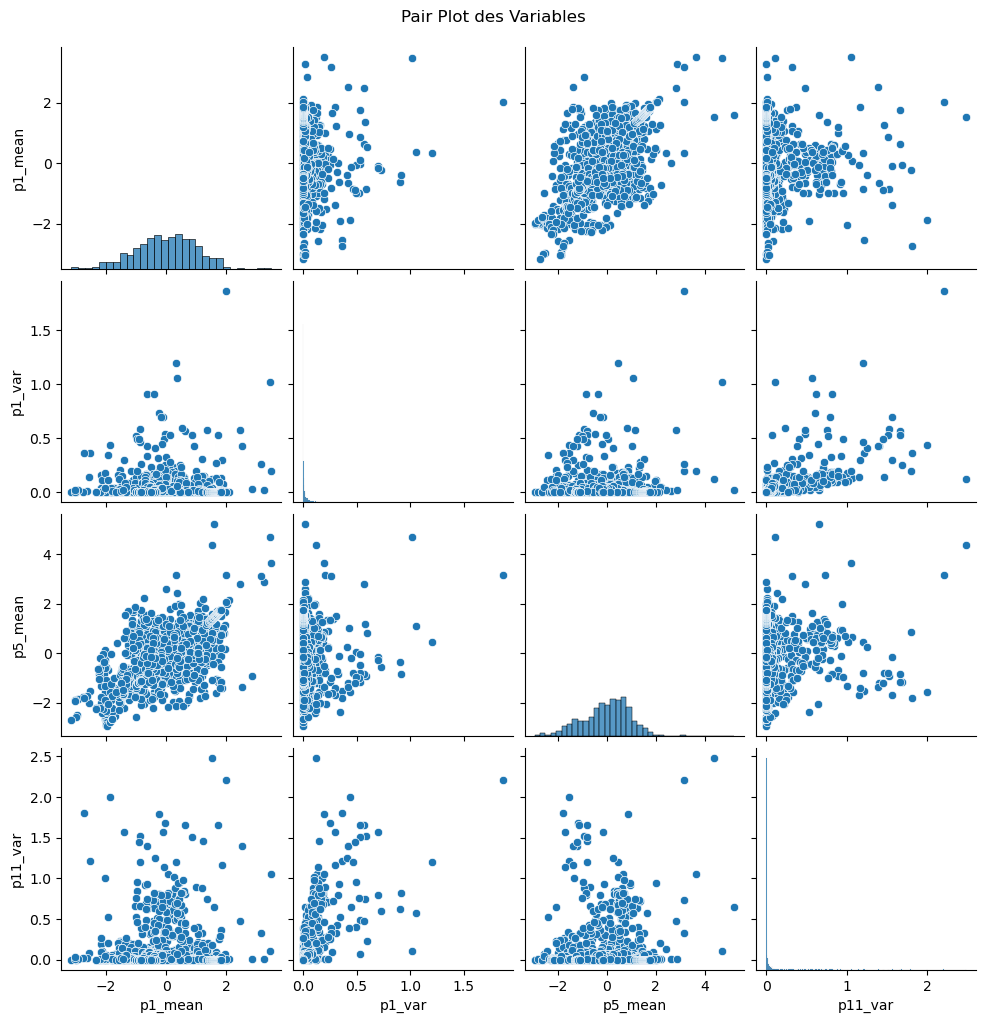

In [109]:
# Sélectionner un sous-ensemble de variables pour le pairplot
selected_vars = ['p1_mean', 'p1_var', 'p5_mean', 'p11_var']  # Adaptez en fonction des colonnes d'intérêt

# Ajouter la colonne 'anomaly' comme couleur
df_pairplot = df[selected_vars]

# Créer un pair plot
sns.pairplot(df_pairplot)
plt.suptitle("Pair Plot des Variables", y=1.02)
plt.show()

Un premier coup d'oeil nous permet assez clairement d'identifier de potentiels outliers.

## **Détection de fenêtres anormales**

### **Sans réduction de la dimensionnalité**

À présent, tentons d'identifier ces outliers par différentes méthodes évoquées lors du dernier TP.  

Nous choisissons d'implémenter:
* la méthode *Elliptic Envelope* pour les moyennes des paramètres ($pn_{mean}$), dans la mesure où elles suivent une distribution presque gaussienne (ce qui est une hypothèse de cette méthode)
* la méthode *Isolation Forest* pour les moyennes et variances ($pn_{mean}$ et $pn_{var}$), car cette méthode ne fait pas d'hypothèse sur la distribution des données
* la méthode *Local Outlier Factor* pour les moyennes et variances ($pn_{mean}$ et $pn_{var}$)
* la méthode *Minimum Covariance Determinant (MCD)* pour les moyennes et variances ($pn_{mean}$ et $pn_{var}$)

Afin de choisir les paramètres de contamination (ou seuils) des ces méthodes d'une manière optimale, commençons par tracer les distances de Mahalanobis de toutes les fenêtres :

/var/folders/xc/rfq5prlx6z993rhxj88tqr480000gn/T/ipykernel_6974/178009115.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(np.dot(np.dot(diffs, inv_cov), diffs.T)))


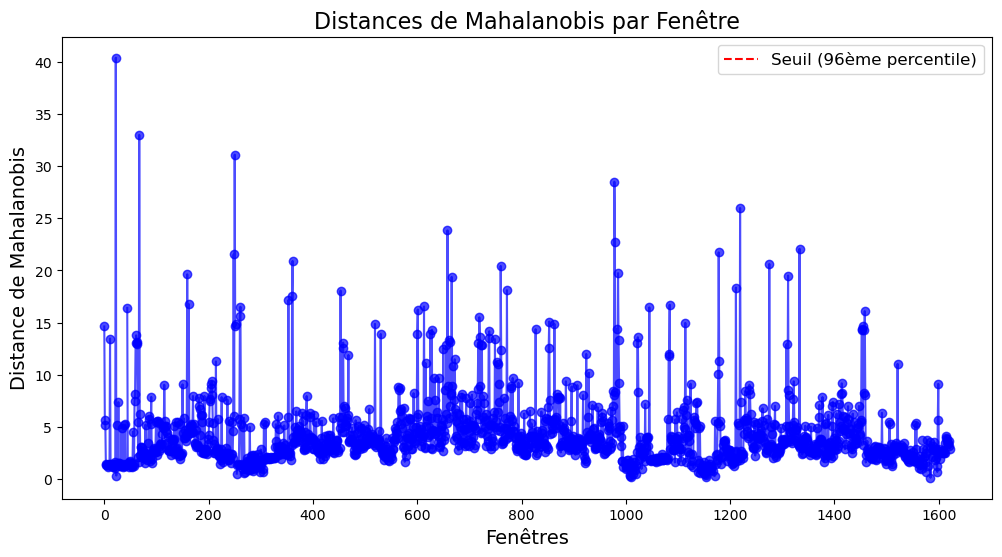

Fenêtres avec des distances élevées (anomalies) : []


In [138]:
features = df.select_dtypes(include=[np.number]).columns
X = df[features]

# Calculer la distance de Mahalanobis pour chaque observation
mahalanobis_distances = mahalanobis_distance(X, X.mean(), covariance_matrix(X))

# Ajouter les distances au DataFrame pour analyse
df['mahalanobis_distance'] = mahalanobis_distances

# Tracer les distances en fonction des fenêtres
plt.figure(figsize=(12, 6))
plt.plot(range(len(mahalanobis_distances)), mahalanobis_distances, marker='o', linestyle='-', color='b', alpha=0.7)
plt.title('Distances de Mahalanobis par Fenêtre', fontsize=16)
plt.xlabel('Fenêtres', fontsize=14)
plt.ylabel('Distance de Mahalanobis', fontsize=14)
plt.axhline(y=np.percentile(mahalanobis_distances, 96), color='red', linestyle='--', label='Seuil (96ème percentile)')
plt.legend(fontsize=12)
plt.show()

# Identifier les fenêtres associées aux anomalies
threshold = np.percentile(mahalanobis_distances, 96)  # Exemple : seuil au 96ème percentile
anomalies = df[df['mahalanobis_distance'] > threshold]

print(f"Fenêtres avec des distances élevées (anomalies) : {anomalies['day_cycle_window'].tolist()}")

De manière visuelle, un seuil de $4$% de fenêtres anormales nous semble raisonnable pour exclure les outliers clairs, sans pour autant se priver de trop de valeurs.

Ainsi, implémentons nos méthodes de détection d'anomalies sur l'ensemble des paramètres, avec un paramètre de contamination de $4$% :  

Pour les trois premières méthodes, on a :

In [123]:
# Sélectionner les colonnes numériques pertinentes
features = df.columns[df.columns.str.contains('_mean|_var')]
means = df.filter(like='_mean').columns

X = df[features]
X_mean = df[means]

# Créer et configurer le modèle Elliptic Envelope
clf_name_ee = 'Elliptic Envelope'
contamination_rate_ee = 0.04  # Proportion d'anomalies estimée
clf_ee = EllipticEnvelope(contamination=contamination_rate_ee)
# Créer et configurer le modèle Isolation Forest
clf_name_if = 'Isolation Forest'
contamination_rate_if = 0.04  # Proportion d'anomalies estimée
clf_if = IsolationForest(n_estimators=100, contamination=contamination_rate_if, random_state=42)
# Créer et configurer le modèle Local Outlier Factor
clf_name_lof = 'Local Outlier Factor'
contamination_rate_lof = 0.04  # Proportion d'anomalies attendue
clf_lof = LocalOutlierFactor(n_neighbors=5, contamination=contamination_rate_lof)


# Entraîner les modèles (et prédire pour LOF)
clf_ee.fit(X_mean)
clf_if.fit(X)
df['anomaly_lof'] = clf_lof.fit_predict(X)

# Prédire les anomalies (-1 = anomalie, 1 = normal)
df['anomaly_ee'] = clf_ee.predict(X_mean)
df['anomaly_if'] = clf_if.predict(X)

# Retenir les anomalies détectées
anomalies_ee = df[df['anomaly_ee'] == -1]['day_cycle_window']
anomalies_if = df[df['anomaly_if'] == -1]['day_cycle_window']
anomalies_lof = df[df['anomaly_lof'] == -1]['day_cycle_window']

# Afficher les anomalies détectées
print(f"Nombre d'anomalies détectées avec {clf_name_ee} : {len(anomalies_ee)}")
print(f"Anomalies détectées avec {clf_name_ee} :")
print(anomalies_ee)
print(f"Nombre d'anomalies détectées avec {clf_name_if} : {len(anomalies_if)}")
print(f"Anomalies détectées avec {clf_name_if} :")
print(anomalies_if)
print(f"Nombre d'anomalies détectées avec {clf_name_lof} : {len(anomalies_lof)}")
print(f"Anomalies détectées avec {clf_name_lof} :")
print(anomalies_lof)


Nombre d'anomalies détectées avec Elliptic Envelope : 65
Anomalies détectées avec Elliptic Envelope :
67        1_2_1
90       1_2_12
115     1_2_142
159       1_2_2
170       1_2_3
         ...   
1415     4_3_24
1452     4_3_58
1453     4_3_59
1457     4_3_62
1459     4_3_64
Name: day_cycle_window, Length: 65, dtype: object
Nombre d'anomalies détectées avec Isolation Forest : 65
Anomalies détectées avec Isolation Forest :
0        1_1_1
22       1_1_3
44       1_1_5
58      1_1_62
60      1_1_64
         ...  
1452    4_3_58
1453    4_3_59
1456    4_3_61
1458    4_3_63
1599    4_4_79
Name: day_cycle_window, Length: 65, dtype: object
Nombre d'anomalies détectées avec Local Outlier Factor : 65
Anomalies détectées avec Local Outlier Factor :
1        1_1_10
2        1_1_11
27       1_1_34
59       1_1_63
60       1_1_64
         ...   
1395     4_2_96
1396     4_2_97
1397     4_2_98
1505    4_4_137
1506    4_4_138
Name: day_cycle_window, Length: 65, dtype: object


Pour la méthode *MCD*, on a :

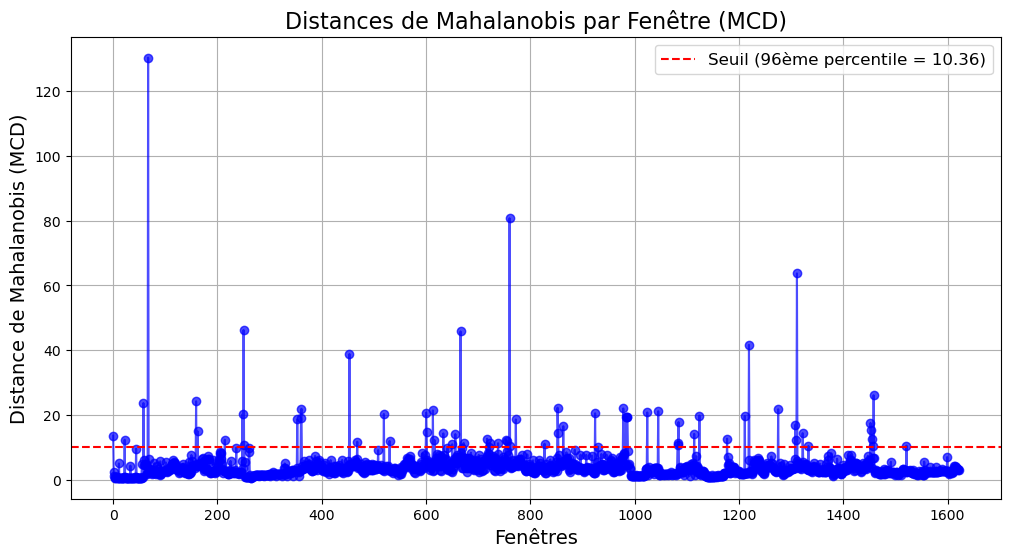

Nombre d'anomalies détectées : 65
Anomalies détectées :  ['1_1_1', '1_1_3', '1_1_62', '1_2_1', '1_2_2', '1_2_22', '1_2_7', '1_3_2', '1_3_4', '1_3_5', '1_5_87', '1_5_93', '2_1_1', '2_1_2', '2_1_33', '2_1_8', '2_1_9', '2_2_63', '2_2_64', '2_2_75', '2_3_1', '2_3_114', '2_3_13', '2_3_135', '2_3_144', '2_3_2', '2_3_60', '2_3_65', '2_3_8', '2_3_93', '2_3_95', '3_1_1', '3_1_10', '3_1_11', '3_1_16', '3_1_2', '3_1_20', '3_1_3', '3_1_85', '3_2_44', '3_2_49', '3_2_50', '3_2_51', '3_3_129', '3_3_148', '3_3_19', '3_3_2', '3_3_20', '3_3_48', '3_3_57', '4_1_15', '4_1_46', '4_2_1', '4_2_15', '4_2_18', '4_2_19', '4_2_2', '4_2_3', '4_2_4', '4_3_58', '4_3_59', '4_3_60', '4_3_61', '4_3_63', '4_4_151']


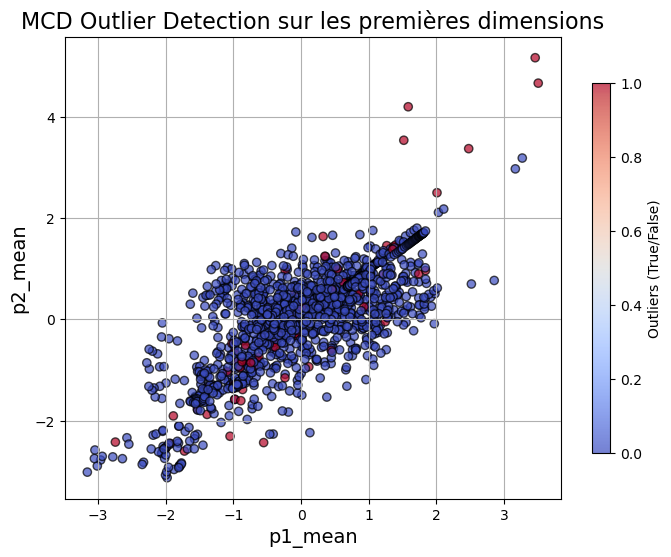

In [124]:
clf_name_mcd = "Minimum Covariance Determinant"

# Convertir en matrice NumPy
data = df[features].values

# Paramètre `h` : 50% des points (ajustable selon vos besoins)
h = int(0.5 * len(data))  

# Appliquer MCD pour calculer les distances
distances = mcd(data, h)

# Définir un seuil pour identifier les outliers (par exemple, 96ème percentile)
threshold = np.percentile(distances, 96)
outliers_pred = distances > threshold
anomalies_mcd = df[outliers_pred]['day_cycle_window']

# Ajouter une colonne 'anomalies_mcd' au DataFrame
df['anomaly_mcd'] = np.where(outliers_pred, -1, 1)

# Tracer les distances de Mahalanobis pour toutes les observations
plt.figure(figsize=(12, 6))
plt.plot(range(len(distances)), distances, marker='o', linestyle='-', color='b', alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Seuil (96ème percentile = {threshold:.2f})')
plt.title('Distances de Mahalanobis par Fenêtre (MCD)', fontsize=16)
plt.xlabel('Fenêtres', fontsize=14)
plt.ylabel('Distance de Mahalanobis (MCD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Résumer les anomalies détectées
print(f"Nombre d'anomalies détectées : {np.sum(outliers_pred)}")
print("Anomalies détectées : ", anomalies_mcd.tolist())

# Optionnel : Visualisation des deux premières dimensions avec outliers
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 2], c=outliers_pred, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("MCD Outlier Detection sur les premières dimensions", fontsize=16)
plt.xlabel(features[0], fontsize=14)  # Première dimension (ex. 'p1_mean')
plt.ylabel(features[2], fontsize=14)  # Deuxième dimension (ex. 'p2_mean')
plt.colorbar(label='Outliers (True/False)', shrink=0.8)
plt.grid(True)
plt.show()

Identifions alors quelles fenêtres ont été détectées anormales par plusieurs méthodes à la fois.

In [125]:
# Retenir les anomalies en commun entre Elliptic Envelope et Isolation Forest
print(f"Anomalies en commun entre {clf_name_ee} et {clf_name_if}:")
print(pd.merge(anomalies_ee, anomalies_if, how='inner', on='day_cycle_window'))

# Retenir les anomalies en commun entre Elliptic Envelope et Local Outlier Factor
print(f"Anomalies en commun entre {clf_name_ee} et {clf_name_lof}:")
print(pd.merge(anomalies_ee, anomalies_lof, how='inner', on='day_cycle_window'))

# Retenir les anomalies en commun entre Elliptic Envelope et MCD
print(f"Anomalies en commun entre {clf_name_ee} et {clf_name_mcd}:")
print(pd.merge(anomalies_ee, anomalies_mcd, how='inner', on='day_cycle_window'))

# Retenir les anomalies en commun entre Isolation Forest et Local Outlier Factor
print(f"Anomalies en commun entre {clf_name_if} et {clf_name_lof}:")
print(pd.merge(anomalies_if, anomalies_lof, how='inner', on='day_cycle_window'))

# Retenir les anomalies en commun entre Isolation Forest et MCD
print(f"Anomalies en commun entre {clf_name_if} et {clf_name_mcd}:")
print(pd.merge(anomalies_if, anomalies_mcd, how='inner', on='day_cycle_window'))

# Retenir les anomalies en commun entre Local Outlier Factor et MCD
print(f"Anomalies en commun entre {clf_name_lof} et {clf_name_mcd}:")
print(pd.merge(anomalies_lof, anomalies_mcd, how='inner', on='day_cycle_window'))

# Retenir les anomalies en commun entre toutes
print(f"Anomalies en commun entre {clf_name_ee}, {clf_name_if}, {clf_name_lof} et {clf_name_mcd}:")
df_temp = pd.merge(anomalies_lof, anomalies_mcd, how='inner', on='day_cycle_window')
df_temp = pd.DataFrame(anomalies_if).merge(df_temp, how='inner', on='day_cycle_window')
df_temp = pd.DataFrame(anomalies_ee).merge(df_temp, how='inner', on='day_cycle_window')
print(df_temp)

Anomalies en commun entre Elliptic Envelope et Isolation Forest:
   day_cycle_window
0             1_2_1
1             1_2_2
2             2_1_1
3             2_1_2
4            2_2_75
5            2_3_60
6            2_3_63
7             3_1_1
8             3_1_3
9            3_2_44
10           3_2_51
11            4_2_1
12            4_2_2
13           4_3_58
14           4_3_59
Anomalies en commun entre Elliptic Envelope et Local Outlier Factor:
  day_cycle_window
0            4_2_1
Anomalies en commun entre Elliptic Envelope et Minimum Covariance Determinant:
   day_cycle_window
0             1_2_1
1             1_2_2
2             2_1_1
3             2_1_2
4            2_2_75
5            2_3_60
6            2_3_65
7             3_1_1
8            3_1_10
9            3_1_11
10           3_1_20
11            3_1_3
12           3_2_44
13           3_2_51
14            4_2_1
15            4_2_2
16           4_3_58
17           4_3_59
Anomalies en commun entre Isolation Forest et Loc

Nous pouvons voir que les méthodes *Elliptic Envelope*, *Isolation Forest* et *MCD* ont beaucoup de fenêtres anormales en commun parmi les $65$ anomalies détectées. En particulier, les méthodes *Isolation Forest* et *MCD* sont très proches.

En revanche, la méthode *Local Outlier Factor* n'a que très peu de fenêtres en commun avec les trois autres méthodes (une seule avec *Elliptic Envelope*, $6$ avec *Isolation Forest*, $3$ avec *MCD*).  

On retrouve le fait que les méthodes agissent différemment dans la détection d'outliers: alors que *Elliptic Envelope* mesure seulement un éloignement des moyennes des fenêtres par rapport à une distribution gaussienne (ellipse), *Isolation Forest* évalue ici la facilité à isoler une fenêtre à partir de sa moyenne **et** de sa variance, et *Local Outlier Factor* détecte les points localement isolés en termes de densité.

De manière générale, une seule fenêtre est détectée par les 4 méthodes : la fenêtre `4_2_1`, qui apparaît alors vraiment anormale. En effet, lorsque nous la représentons, nous constatons des séries temporelles très différentes des séries de fenêtres quelconques (que l'on peut visualiser en début de notebook) :

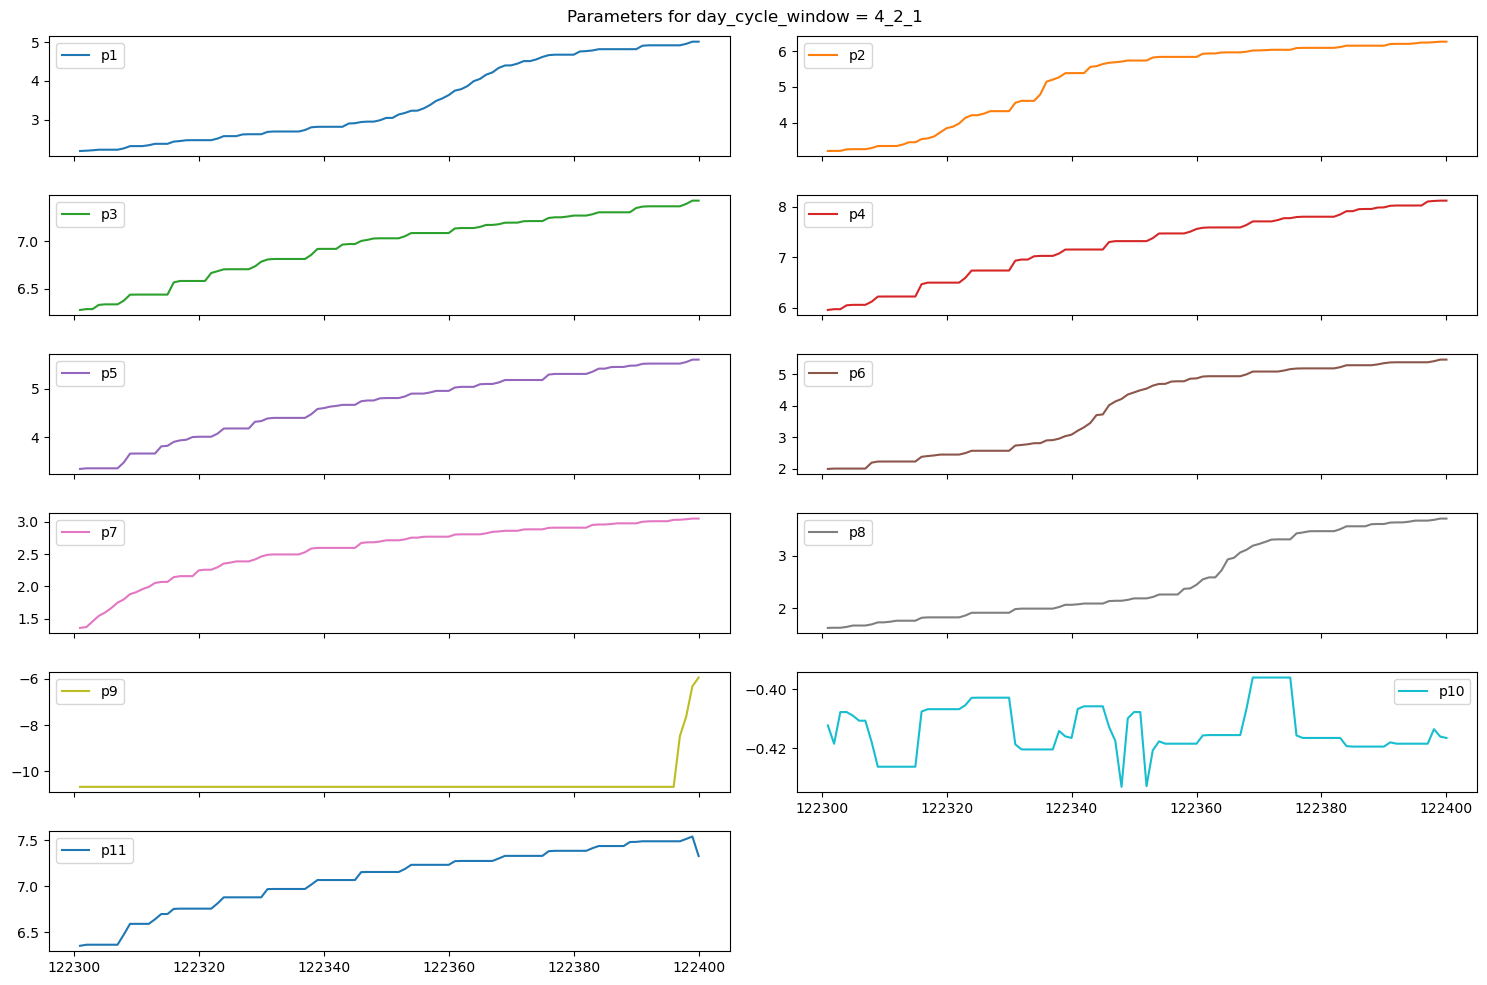

In [114]:
example_df = df_base_filtered[df_base_filtered['day_cycle_window'] == '4_2_1']

# Plot the values of all parameters
example_df.plot(kind='line', subplots=True, layout=(len(example_df.columns)//2, 2), figsize=(15, 10), title=f'Parameters for day_cycle_window = 4_2_1')
plt.tight_layout()
plt.show()

À présent, visualisons les outliers détectés par les différentes méthodes pour quelques paramètres :

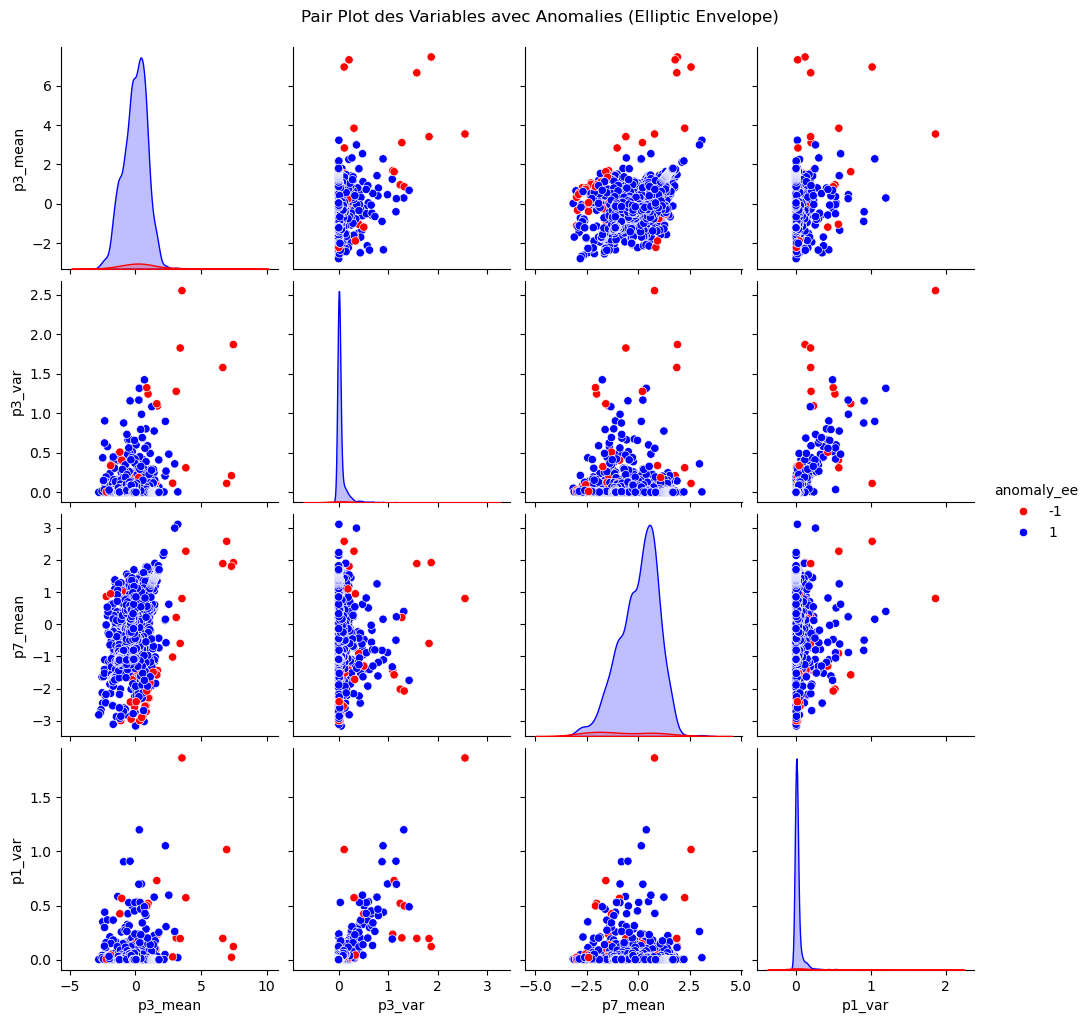

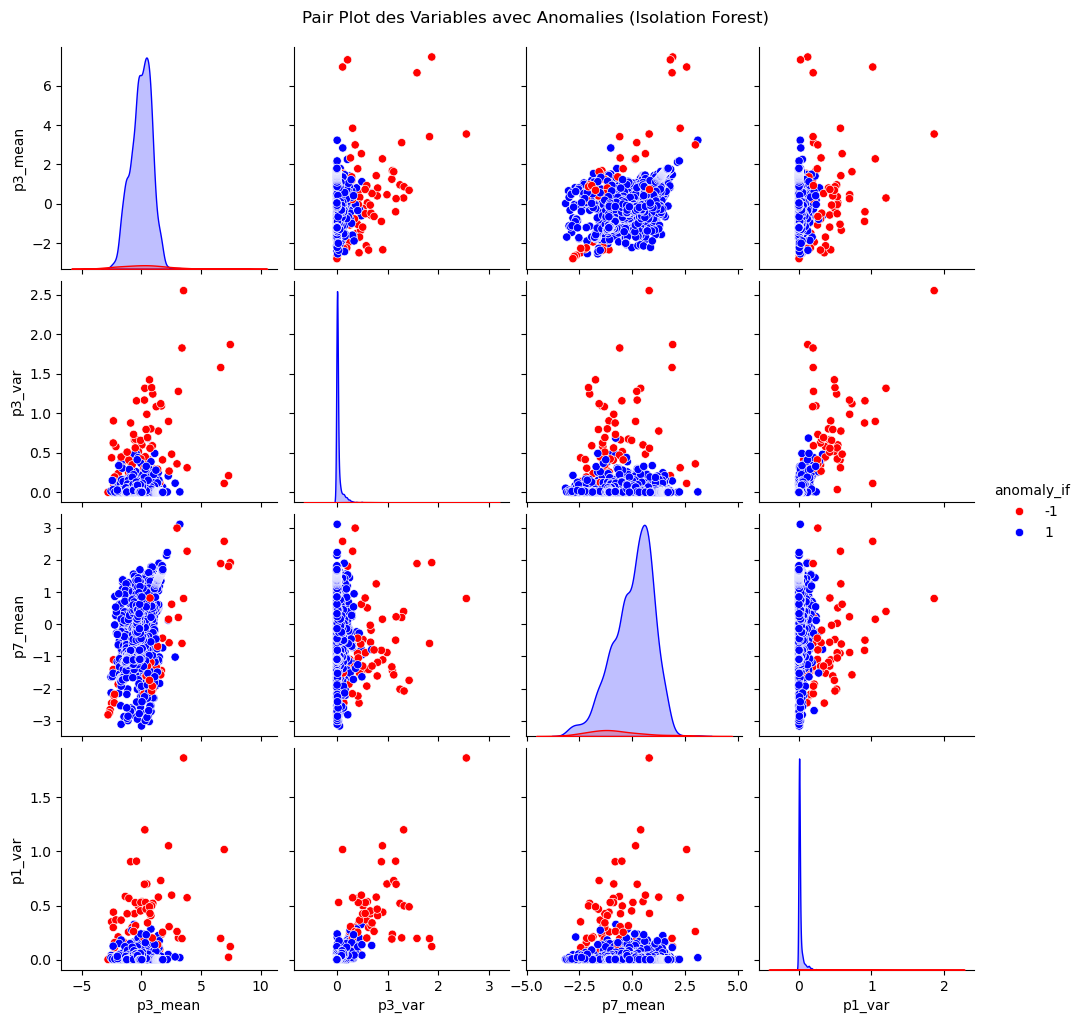

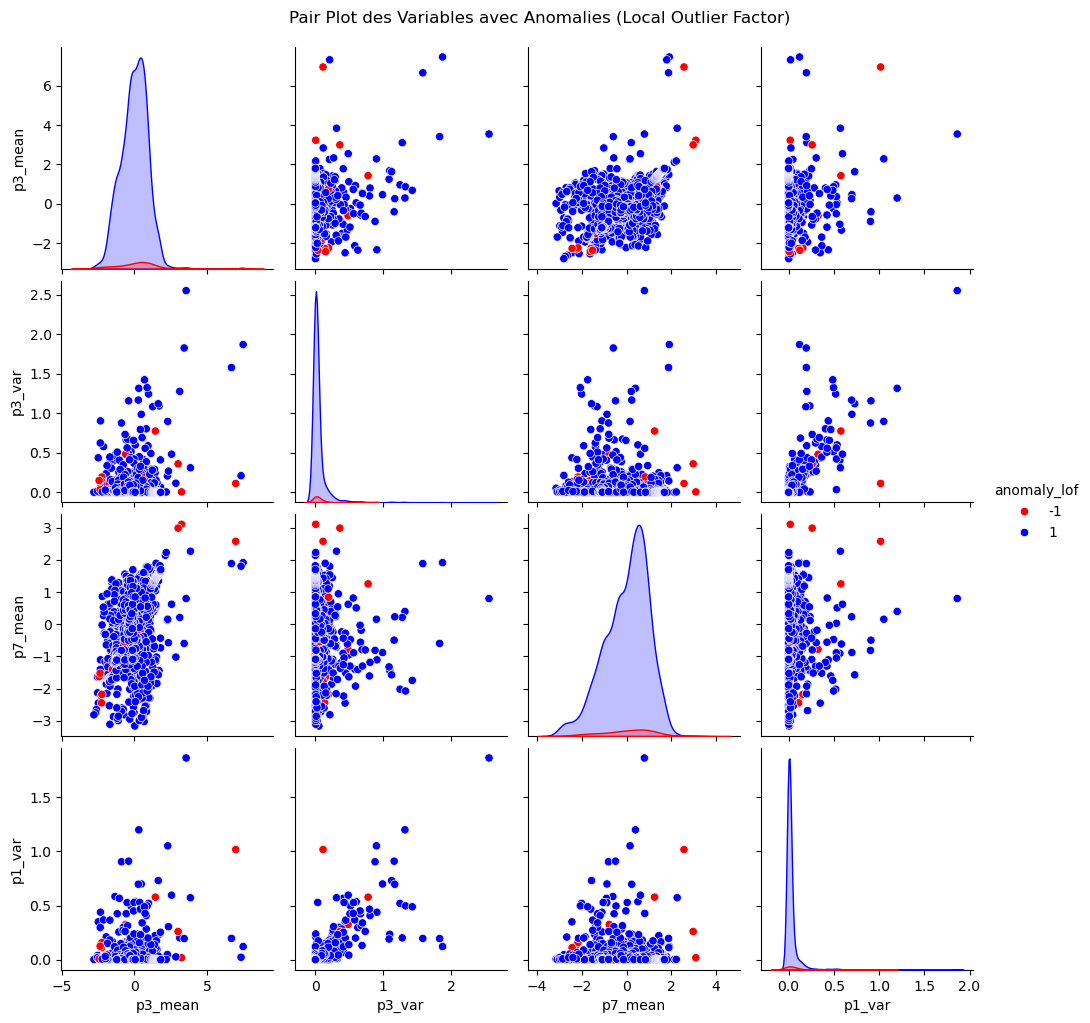

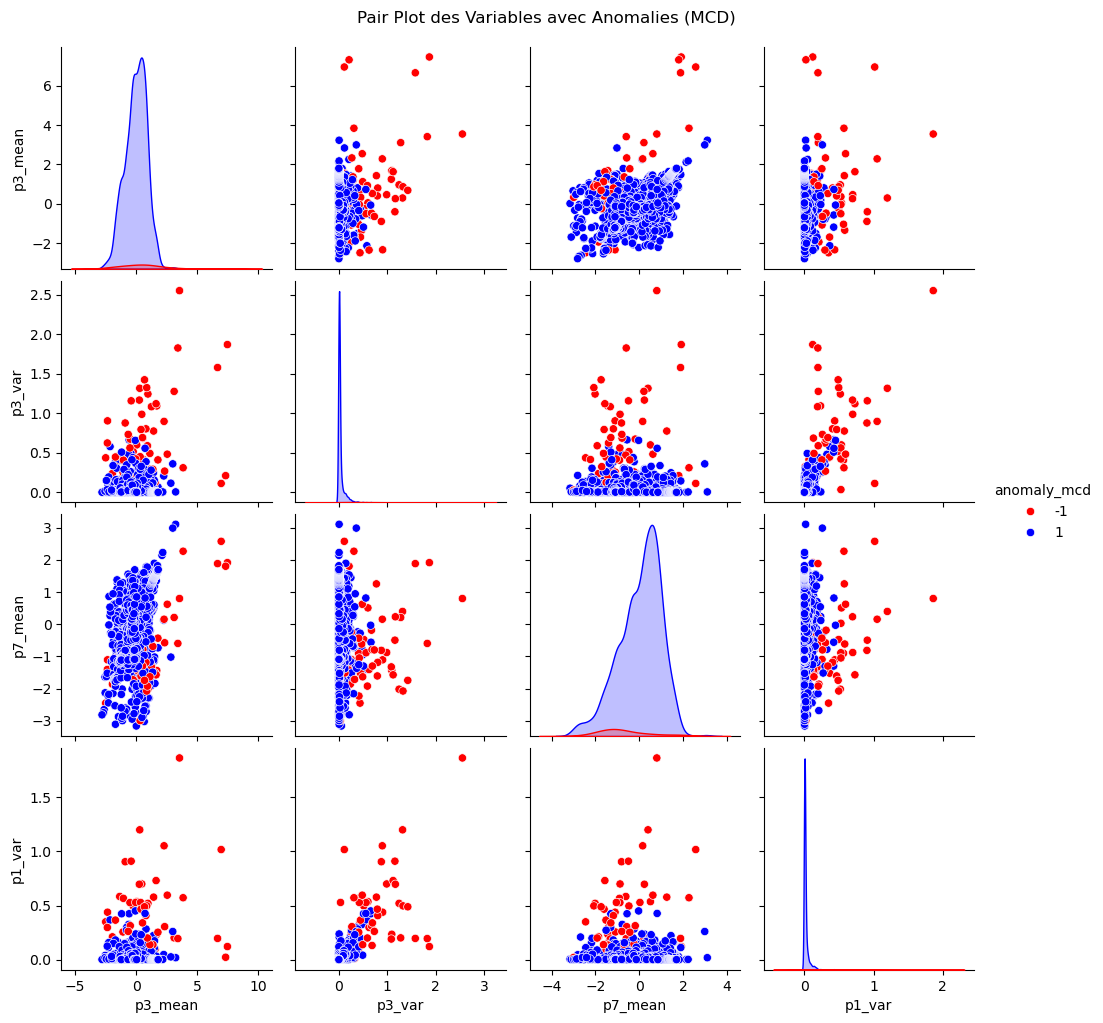

In [126]:
# Sélectionner un sous-ensemble de variables pour le pairplot
selected_vars = ['p3_mean', 'p3_var', 'p7_mean', 'p1_var']  # Adaptez en fonction des colonnes d'intérêt

# Ajouter la colonne 'anomaly' comme couleur
df_pairplot = df[selected_vars + ['anomaly_ee']]

# Créer un pair plot
sns.pairplot(df_pairplot, hue='anomaly_ee', palette={1: "blue", -1: "red"})
plt.suptitle("Pair Plot des Variables avec Anomalies (Elliptic Envelope)", y=1.02)
plt.show()

# Ajouter la colonne 'anomaly' comme couleur
df_pairplot = df[selected_vars + ['anomaly_if']]

# Créer un pair plot
sns.pairplot(df_pairplot, hue='anomaly_if', palette={1: "blue", -1: "red"})
plt.suptitle("Pair Plot des Variables avec Anomalies (Isolation Forest)", y=1.02)
plt.show()

# Ajouter la colonne 'anomaly' comme couleur
df_pairplot = df[selected_vars + ['anomaly_lof']]

# Créer un pair plot
sns.pairplot(df_pairplot, hue='anomaly_lof', palette={1: "blue", -1: "red"})
plt.suptitle("Pair Plot des Variables avec Anomalies (Local Outlier Factor)", y=1.02)
plt.show()

# Ajouter la colonne 'anomaly' comme couleur
df_pairplot = df[selected_vars + ['anomaly_mcd']]

# Créer un pair plot
sns.pairplot(df_pairplot, hue='anomaly_mcd', palette={1: "blue", -1: "red"})
plt.suptitle("Pair Plot des Variables avec Anomalies (MCD)", y=1.02)
plt.show()


On remarque que les méthodes *Isolation Forest* et *MCD* sont particulièrement performantes pour détecter les fenêtres visiblement anormales, là où *Elliptic Envelope* et *Local Outlier Factor* semblent moins efficaces. Pour *Elliptic Envelope*, cela est probablement dû à l'invalidité de l'hypothèse de normalité des données, en tous cas lorsqu'il s'agit des variances.

On constate sur les projections 2D que certains points sont détectés comme anormaux alors qu'ils sont au sein de zones denses des nuages de points. Cela s'explique par le fait que $2$ dimensions ne suffisent pas à visualiser des fenêtres qui sont elles anormales au sens de $22$ paramètres.

### **Avec réduction de la dimmensionnalité**

Ce constat, en plus de la volonté de simplifier notre problème, nous invite à réaliser une réduction de dimension *via* une *PCA* :

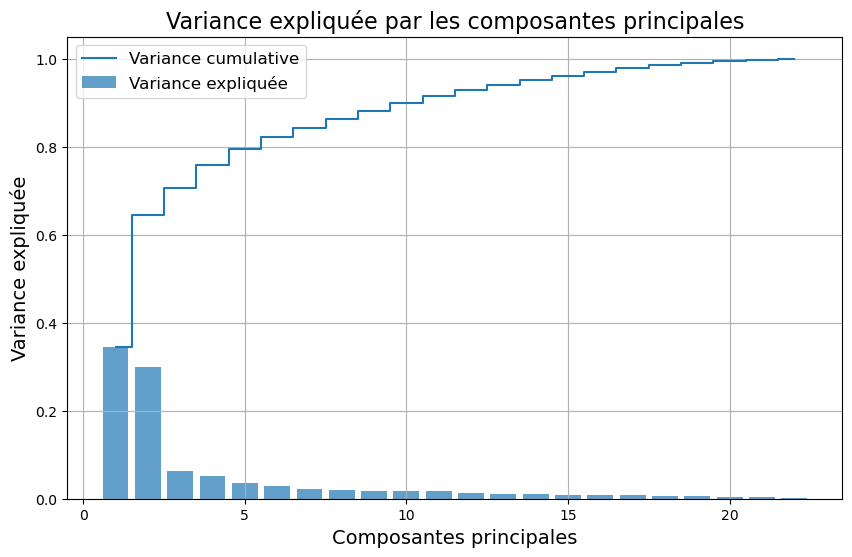

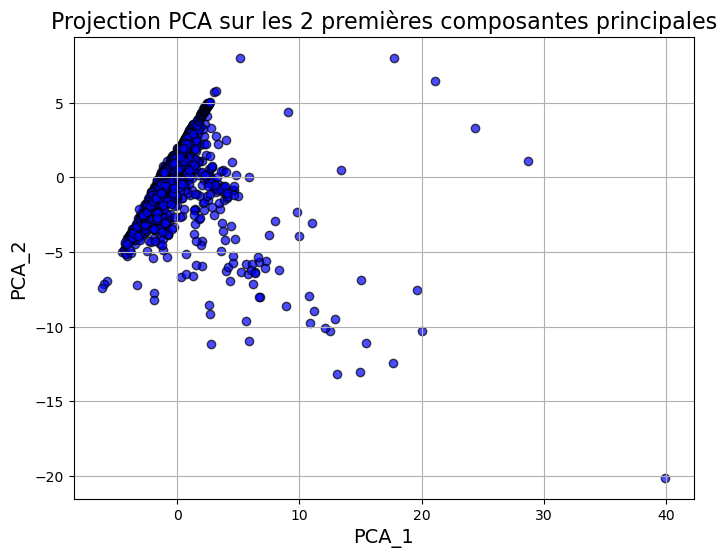

In [127]:
data = df[features]

# Standardiser les données (important pour la PCA)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Appliquer la PCA
pca = PCA()
pca_result = pca.fit_transform(data_scaled)

# Variance expliquée par chaque composante principale
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Afficher les résultats de la variance expliquée
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Variance expliquée')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Variance cumulative')
plt.xlabel('Composantes principales', fontsize=14)
plt.ylabel('Variance expliquée', fontsize=14)
plt.title('Variance expliquée par les composantes principales', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Visualiser les données projetées sur les 2 premières composantes principales
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='b', alpha=0.7, edgecolor='k')
plt.xlabel('PCA_1', fontsize=14)
plt.ylabel('PCA_2', fontsize=14)
plt.title('Projection PCA sur les 2 premières composantes principales', fontsize=16)
plt.grid(True)
plt.show()

# (Optionnel) Ajouter les résultats PCA dans le DataFrame original
df['PCA_1'] = pca_result[:, 0]
df['PCA_2'] = pca_result[:, 1]

Nous constatons que la majorité de la variance est expliquée par les deux premières composantes principales : celles-ci nous permettent ici de très bien séparer visuellement (en 2D) les outliers des fenêtres "classiques".  

Nous décidons donc de conserver ces deux premières composantes principales, puis d'appliquer à nouveau nos $4$ méthodes de détection d'outliers :

In [128]:
# Sélectionner les colonnes numériques pertinentes
features_PCA = df.filter(like='PCA_').columns
X_PCA = df[features_PCA]

# Créer et configurer le modèle Elliptic Envelope
clf_name_ee = 'Elliptic Envelope'
contamination_rate_ee = 0.04  # Proportion d'anomalies estimée
clf_ee_PCA = EllipticEnvelope(contamination=contamination_rate_ee)
# Créer et configurer le modèle Isolation Forest
clf_name_if = 'Isolation Forest'
contamination_rate_if = 0.04  # Proportion d'anomalies estimée
clf_if_PCA = IsolationForest(n_estimators=100, contamination=contamination_rate_if, random_state=42)
# Créer et configurer le modèle Local Outlier Factor
clf_name_lof = 'Local Outlier Factor'
contamination_rate_lof = 0.04  # Proportion d'anomalies attendue
clf_lof_PCA = LocalOutlierFactor(n_neighbors=5, contamination=contamination_rate_lof)


# Entraîner les modèles (et prédire pour LOF)
clf_ee_PCA.fit(X_PCA)
clf_if_PCA.fit(X_PCA)
df['anomaly_lof_PCA'] = clf_lof_PCA.fit_predict(X_PCA)

# Prédire les anomalies (-1 = anomalie, 1 = normal)
df['anomaly_ee_PCA'] = clf_ee_PCA.predict(X_PCA)
df['anomaly_if_PCA'] = clf_if_PCA.predict(X_PCA)

# Retenir les anomalies détectées
anomalies_ee_PCA = df[df['anomaly_ee_PCA'] == -1]['day_cycle_window']
anomalies_if_PCA = df[df['anomaly_if_PCA'] == -1]['day_cycle_window']
anomalies_lof_PCA = df[df['anomaly_lof_PCA'] == -1]['day_cycle_window']

# Afficher les anomalies détectées
print(f"Nombre d'anomalies détectées avec {clf_name_ee} : {len(anomalies_ee_PCA)}")
print(f"Anomalies détectées avec {clf_name_ee} :")
print(anomalies_ee_PCA)
print(f"Nombre d'anomalies détectées avec {clf_name_if} : {len(anomalies_if_PCA)}")
print(f"Anomalies détectées avec {clf_name_if} :")
print(anomalies_if_PCA)
print(f"Nombre d'anomalies détectées avec {clf_name_lof} : {len(anomalies_lof_PCA)}")
print(f"Anomalies détectées avec {clf_name_lof} :")
print(anomalies_lof_PCA)


Nombre d'anomalies détectées avec Elliptic Envelope : 65
Anomalies détectées avec Elliptic Envelope :
0        1_1_1
44       1_1_5
58      1_1_62
67       1_2_1
159      1_2_2
         ...  
1453    4_3_59
1455    4_3_60
1456    4_3_61
1458    4_3_63
1599    4_4_79
Name: day_cycle_window, Length: 65, dtype: object
Nombre d'anomalies détectées avec Isolation Forest : 65
Anomalies détectées avec Isolation Forest :
0        1_1_1
11       1_1_2
58      1_1_62
60      1_1_64
61      1_1_65
         ...  
1322     4_2_3
1452    4_3_58
1453    4_3_59
1458    4_3_63
1599    4_4_79
Name: day_cycle_window, Length: 65, dtype: object
Nombre d'anomalies détectées avec Local Outlier Factor : 65
Anomalies détectées avec Local Outlier Factor :
24      1_1_31
27      1_1_34
37      1_1_43
40      1_1_46
60      1_1_64
         ...  
1435    4_3_42
1452    4_3_58
1557    4_4_40
1598    4_4_78
1599    4_4_79
Name: day_cycle_window, Length: 65, dtype: object


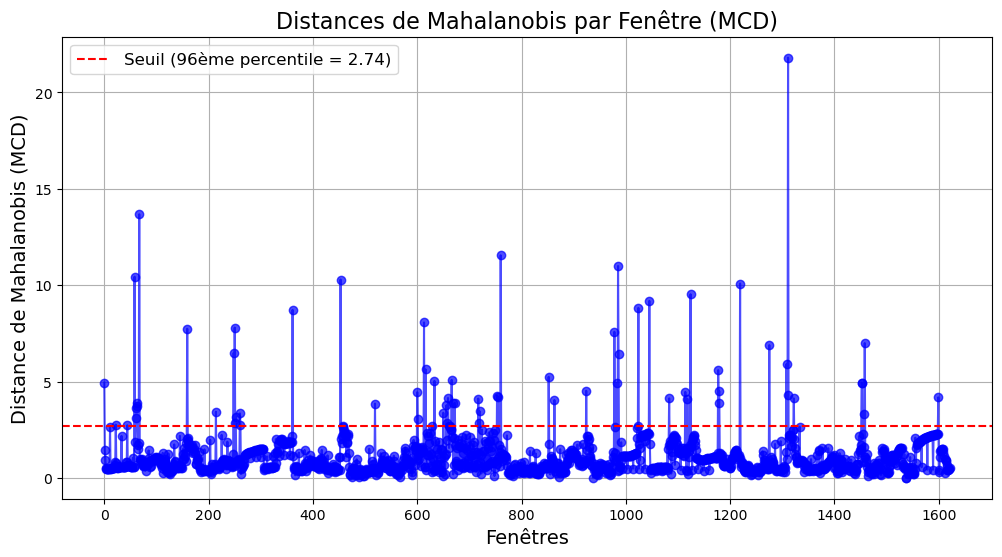

Nombre d'anomalies détectées : 65
Anomalies détectées :  ['1_1_1', '1_1_3', '1_1_62', '1_2_1', '1_2_2', '1_2_22', '1_2_7', '1_3_2', '1_3_4', '1_3_5', '1_5_87', '1_5_93', '2_1_1', '2_1_2', '2_1_33', '2_1_8', '2_1_9', '2_2_63', '2_2_64', '2_2_75', '2_3_1', '2_3_114', '2_3_13', '2_3_135', '2_3_144', '2_3_2', '2_3_60', '2_3_65', '2_3_8', '2_3_93', '2_3_95', '3_1_1', '3_1_10', '3_1_11', '3_1_16', '3_1_2', '3_1_20', '3_1_3', '3_1_85', '3_2_44', '3_2_49', '3_2_50', '3_2_51', '3_3_129', '3_3_148', '3_3_19', '3_3_2', '3_3_20', '3_3_48', '3_3_57', '4_1_15', '4_1_46', '4_2_1', '4_2_15', '4_2_18', '4_2_19', '4_2_2', '4_2_3', '4_2_4', '4_3_58', '4_3_59', '4_3_60', '4_3_61', '4_3_63', '4_4_151']


In [129]:
clf_name_mcd = "Minimum Covariance Determinant"

# Convertir en matrice NumPy
data = df[features_PCA].values

# Paramètre `h` : 50% des points (ajustable selon vos besoins)
h = int(0.5 * len(data))  

# Appliquer MCD pour calculer les distances
distances = mcd(data, h)

# Définir un seuil pour identifier les outliers (par exemple, 97ème percentile)
threshold = np.percentile(distances, 96)
outliers_pred = distances > threshold
anomalies_mcd_PCA = df[outliers_pred]['day_cycle_window']

# Ajouter une colonne 'anomalies_mcd' au DataFrame
df['anomaly_mcd_PCA'] = np.where(outliers_pred, -1, 1)

# Tracer les distances de Mahalanobis pour toutes les observations
plt.figure(figsize=(12, 6))
plt.plot(range(len(distances)), distances, marker='o', linestyle='-', color='b', alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Seuil (96ème percentile = {threshold:.2f})')
plt.title('Distances de Mahalanobis par Fenêtre (MCD)', fontsize=16)
plt.xlabel('Fenêtres', fontsize=14)
plt.ylabel('Distance de Mahalanobis (MCD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Résumer les anomalies détectées
print(f"Nombre d'anomalies détectées : {np.sum(outliers_pred)}")
print("Anomalies détectées : ", anomalies_mcd.tolist())

Visualisons maintenant sur les deux composantes principales retenues :

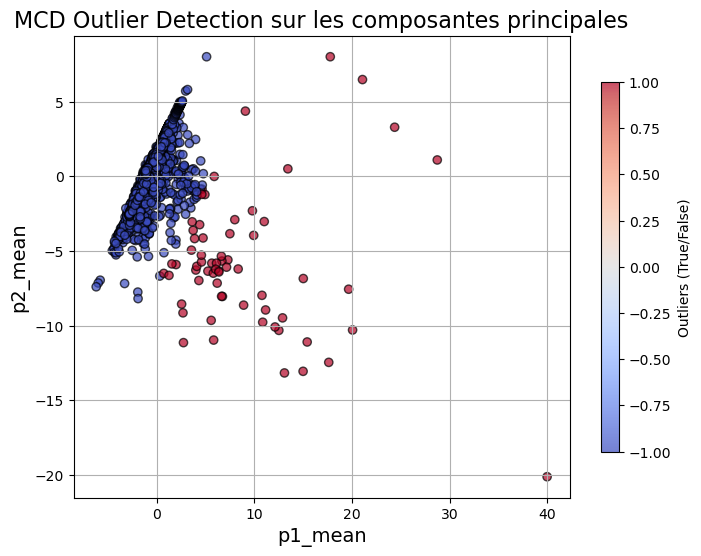

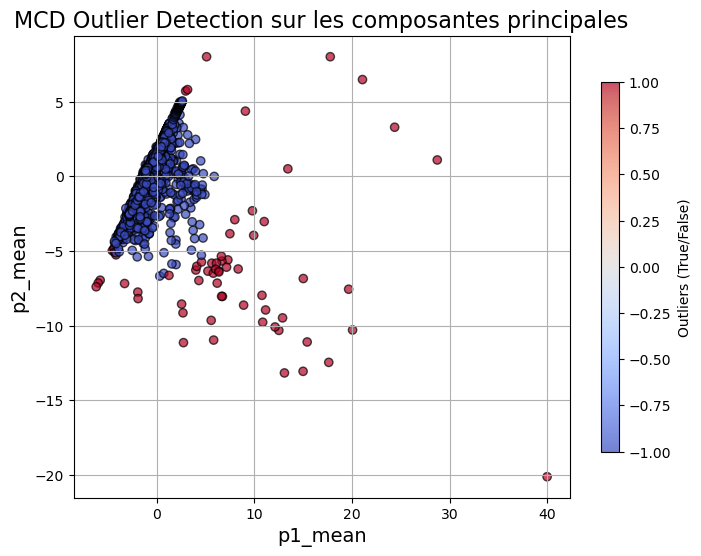

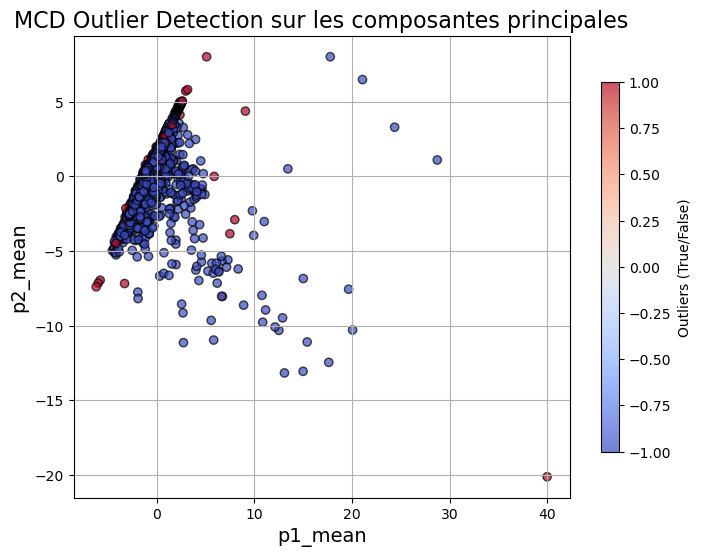

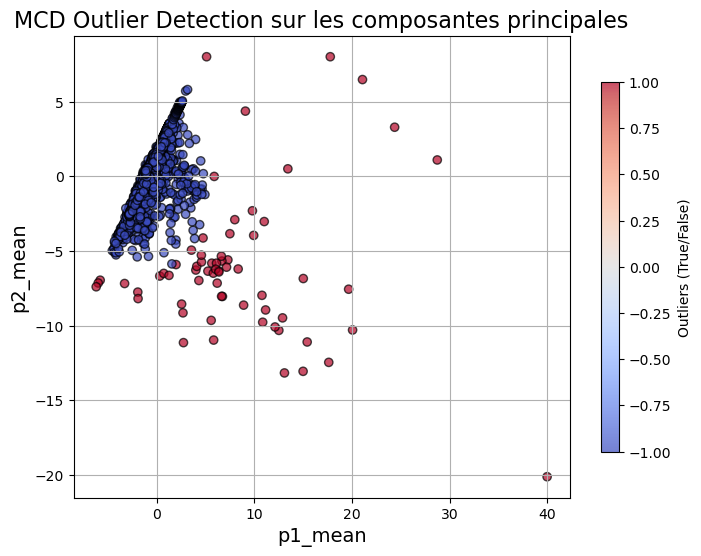

In [130]:
# Visualisatio
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=-df['anomaly_ee_PCA'], cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("MCD Outlier Detection sur les composantes principales", fontsize=16)
plt.xlabel(features[0], fontsize=14)  # Première dimension (ex. 'p1_mean')
plt.ylabel(features[2], fontsize=14)  # Deuxième dimension (ex. 'p2_mean')
plt.colorbar(label='Outliers (True/False)', shrink=0.8)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=-df['anomaly_if_PCA'], cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("MCD Outlier Detection sur les composantes principales", fontsize=16)
plt.xlabel(features[0], fontsize=14)  # Première dimension (ex. 'p1_mean')
plt.ylabel(features[2], fontsize=14)  # Deuxième dimension (ex. 'p2_mean')
plt.colorbar(label='Outliers (True/False)', shrink=0.8)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=-df['anomaly_lof_PCA'], cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("MCD Outlier Detection sur les composantes principales", fontsize=16)
plt.xlabel(features[0], fontsize=14)  # Première dimension (ex. 'p1_mean')
plt.ylabel(features[2], fontsize=14)  # Deuxième dimension (ex. 'p2_mean')
plt.colorbar(label='Outliers (True/False)', shrink=0.8)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=-df['anomaly_mcd_PCA'], cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("MCD Outlier Detection sur les composantes principales", fontsize=16)
plt.xlabel(features[0], fontsize=14)  # Première dimension (ex. 'p1_mean')
plt.ylabel(features[2], fontsize=14)  # Deuxième dimension (ex. 'p2_mean')
plt.colorbar(label='Outliers (True/False)', shrink=0.8)
plt.grid(True)
plt.show()

Comme attendu, la visualisation est bien plus parlante étant donné que les fenêtres anormales détectées l'ont été sur les deux composantes principales, que nous sommes en mesure de représenter en 2D.  

La méthode *Local Outlier Factor* donne encore une fois des résultats peu satisfaisants.

Pour finir, implémentons un vote majoritaire entre les trois méthodes donnant les meilleurs résultats (ainsi, nous excluons la méthode *Local Outlier Factor* et nous disposons d'un nombre impair de $3$ votes) : 

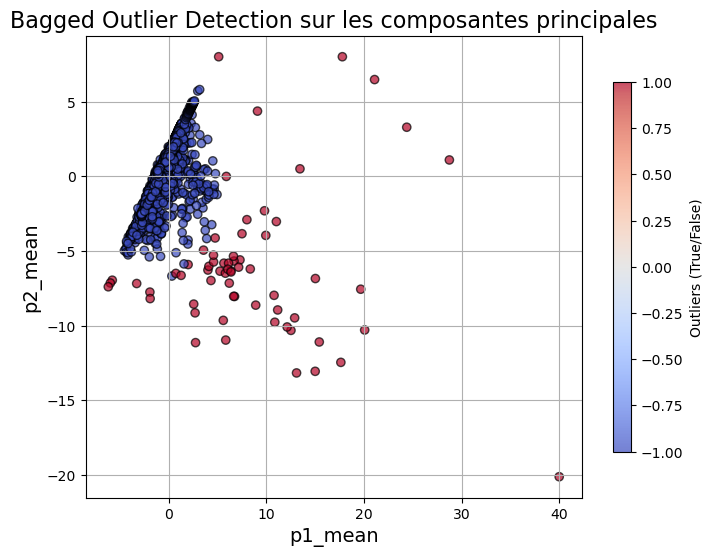

Fenêtres anormales finales :  ['1_1_1', '1_1_5', '1_1_62', '1_1_64', '1_1_65', '1_1_66', '1_1_67', '1_2_1', '1_2_2', '1_2_7', '1_3_2', '1_3_4', '1_3_5', '1_4_1', '1_4_2', '1_4_3', '2_1_1', '2_1_2', '2_1_8', '2_2_63', '2_2_64', '2_2_75', '2_3_1', '2_3_114', '2_3_13', '2_3_135', '2_3_137', '2_3_138', '2_3_144', '2_3_16', '2_3_2', '2_3_60', '2_3_62', '2_3_63', '2_3_93', '2_3_95', '3_1_1', '3_1_2', '3_1_3', '3_1_85', '3_2_44', '3_2_49', '3_2_50', '3_2_51', '3_3_129', '3_3_148', '3_3_2', '3_3_48', '3_3_51', '3_3_57', '4_1_15', '4_1_16', '4_1_17', '4_2_1', '4_2_15', '4_2_18', '4_2_19', '4_2_2', '4_2_3', '4_3_58', '4_3_59', '4_3_61', '4_3_63', '4_4_79']


In [131]:
# Calculer le vote majoritaire
df['anomaly_final'] = df[['anomaly_ee_PCA', 'anomaly_if_PCA', 'anomaly_mcd_PCA']].sum(axis=1)
df['anomaly_final'] = np.where(df['anomaly_final'] >= 0, 1, -1)

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=-df['anomaly_final'], cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("Bagged Outlier Detection sur les composantes principales", fontsize=16)
plt.xlabel(features[0], fontsize=14)  # Première dimension (ex. 'p1_mean')
plt.ylabel(features[2], fontsize=14)  # Deuxième dimension (ex. 'p2_mean')
plt.colorbar(label='Outliers (True/False)', shrink=0.8)
plt.grid(True)
plt.show()

# Résumer les anomalies détectées
print("Fenêtres anormales finales : ", df[df['anomaly_final'] == -1]['day_cycle_window'].tolist())

### **Fenêtres anormales retenues**

En conclusion, voici les fenêtres anormales retenues à l'issue de notre investigation :
```
'1_1_1', '1_1_5', '1_1_62', '1_1_64', '1_1_65', '1_1_66', '1_1_67', '1_2_1', '1_2_2', '1_2_7', '1_3_2', '1_3_4', '1_3_5', '1_4_1', '1_4_2', '1_4_3', '2_1_1', '2_1_2', '2_1_8', '2_2_63', '2_2_64', '2_2_75', '2_3_1', '2_3_114', '2_3_13', '2_3_135', '2_3_137', '2_3_138', '2_3_144', '2_3_16', '2_3_2', '2_3_60', '2_3_62', '2_3_63', '2_3_93', '2_3_95', '3_1_1', '3_1_2', '3_1_3', '3_1_85', '3_2_44', '3_2_49', '3_2_50', '3_2_51', '3_3_129', '3_3_148', '3_3_2', '3_3_48', '3_3_51', '3_3_57', '4_1_15', '4_1_16', '4_1_17', '4_2_1', '4_2_15', '4_2_18', '4_2_19', '4_2_2', '4_2_3', '4_3_58', '4_3_59', '4_3_61', '4_3_63', '4_4_79'

Pour y voir plus clair, déterminons les cycles et jours concernés par le caractère anormal mis en évidence :

In [136]:
# Filtrer les fenêtres anormales
fenetres_anormales = df[df['anomaly_final'] == -1][['day_cycle_window']].copy()

# Séparer les colonnes `day`, `cycle`, `window` à partir de la chaîne de caractères
fenetres_anormales[['day', 'cycle', 'window']] = fenetres_anormales['day_cycle_window'].str.split('_', expand=True)

# Compter le nombre de valeurs pour chaque combinaison de `day` et `cycle`
counts = fenetres_anormales.groupby(['day', 'cycle']).size().reset_index(name='nombre')

# Classer les `day` et `cycle` selon les fréquences les plus élevées
sorted_counts = counts.sort_values(by='nombre', ascending=False).reset_index(drop=True)

# Afficher les résultats
print("Classement des combinaisons (day, cycle) par fréquence :")
print(sorted_counts)

# Compter les valeurs globales pour chaque `day` et `cycle` indépendamment
day_counts = fenetres_anormales['day'].value_counts().reset_index()
cycle_counts = fenetres_anormales['cycle'].value_counts().reset_index()

day_counts.columns = ['day', 'nombre']
cycle_counts.columns = ['cycle', 'nombre']

# Classer les `day` et `cycle` selon leur fréquence totale
print("\nClassement des `day` selon le total de valeurs associées :")
print(day_counts.reset_index(drop=True))

print("\nClassement des `cycle` selon le total de valeurs associées :")
print(cycle_counts.reset_index(drop=True))

Classement des combinaisons (day, cycle) par fréquence :
   day cycle  nombre
0    2     3      14
1    1     1       7
2    3     3       6
3    4     2       6
4    3     1       4
5    3     2       4
6    4     3       4
7    1     2       3
8    1     3       3
9    1     4       3
10   2     1       3
11   2     2       3
12   4     1       3
13   4     4       1

Classement des `day` selon le total de valeurs associées :
  day  nombre
0   2      20
1   1      16
2   3      14
3   4      14

Classement des `cycle` selon le total de valeurs associées :
  cycle  nombre
0     3      27
1     1      17
2     2      16
3     4       4


## **Conclusion générale**

Nous constatons que le 3ème cycle du 2ème jour comporte beaucoup de fenêtres anormales par rapport aux autres combinaisons "jour-cycle" ($2$ fois plus que la combinaison suivante dans le classement), à tel point que le 2ème jour est le jour avec le plus de fenêtres anormales, et le 3ème cycle le cycle le plus anormal des 4 cycles.

Notons par ailleurs que le 3ème cycle reste problématique en dehors du 2ème jour, avec $6$ fenêtres anormales le 3ème jour, et $4$ le 4ème jour.

Ainsi, il semblerait que le 3ème cycle d'un jour donné soit particulièrement propice au relevé de fenêtres anormales, et que ce fût particulièrement le cas lors du 2ème jour.

Enfin, souvenons-nous que la fenêtre `4_2_1` est la seule à avoir été identifiée anormale par toutes les méthodes employée, ce qui dénote un épiphénomène remarquable, ou bien un dysfonctionnement significatif du dispositif de mesure.
